In [62]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [63]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [64]:
filter=confirmed_df['Country/Region']=='US'
cols = confirmed_df.keys()
confirmed = confirmed_df[filter].loc[:, cols[4]:cols[-1]]

cols = deaths_df.keys()
filter=deaths_df['Country/Region']=='US'
deaths = deaths_df[filter].loc[:, cols[4]:cols[-1]]

cols = recoveries_df.keys()
filter=recoveries_df['Country/Region']=='US'
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [65]:
confirmed_dates = confirmed.keys()
death_dates= deaths.keys()
recoveries_dates=recoveries.keys()

In [66]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(confirmed_dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

death_future_forcast = np.array([i for i in range(len(death_dates)+days_in_future)]).reshape(-1, 1)
death_adjusted_dates = future_forcast[:-10]

In [67]:
days_since_1_22 = np.array([i for i in range(len(confirmed_dates))]).reshape(-1, 1)

death_days_since_1_22 = np.array([i for i in range(len(death_dates))]).reshape(-1, 1)

In [68]:
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
us_cases = [] 

for i in confirmed_dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    
us_deaths=[]

for i in death_dates:
    # case studies 
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())


In [69]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, us_cases, test_size=0.05, shuffle=False) 

In [70]:
poly = PolynomialFeatures(degree=6)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [71]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.0s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=False, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=40, n_jobs=-1,
          param_distributions={'tol': [0.0001, 0.001, 0.01], 'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001], 'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001], 'lambda_1': [1e-07, 1e-06, 1e-05, 0.0001], 'lambda_2': [1e-07, 1e-06, 1e-05, 0.0001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=1)

In [72]:
bayesian_search.best_params_

{'tol': 0.01,
 'lambda_2': 0.0001,
 'lambda_1': 1e-06,
 'alpha_2': 0.0001,
 'alpha_1': 0.0001}

In [73]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 888894.8589979323
MSE: 880335944734.9869


In [74]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 433321.8624353558
MSE: 253815866383.10367


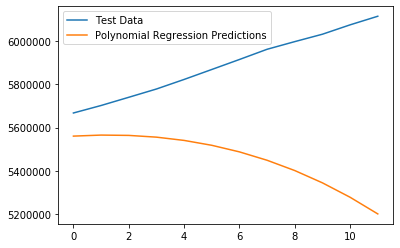

In [75]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

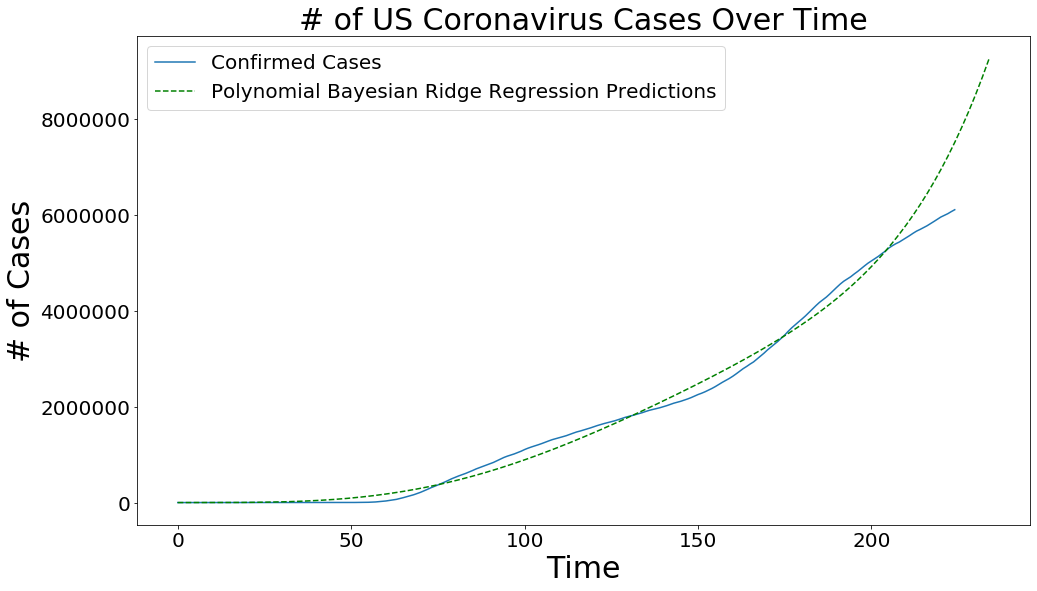

In [76]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, us_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of US Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [77]:
X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(death_days_since_1_22, us_deaths, test_size=0.05, shuffle=False) 

In [78]:
poly = PolynomialFeatures(degree=6)
poly_X_train_death = poly.fit_transform(X_train_death)
poly_X_test_death = poly.fit_transform(X_test_death)
death_poly_future_forcast = poly.fit_transform(death_future_forcast)

In [79]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_death, y_train_death)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.0s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=False, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=40, n_jobs=-1,
          param_distributions={'tol': [0.0001, 0.001, 0.01], 'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001], 'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001], 'lambda_1': [1e-07, 1e-06, 1e-05, 0.0001], 'lambda_2': [1e-07, 1e-06, 1e-05, 0.0001]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=1)

In [80]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_death)
bayesian_pred = bayesian_confirmed.predict(death_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_death))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_death))

MAE: 42483.00983617633
MSE: 2112591074.3494432


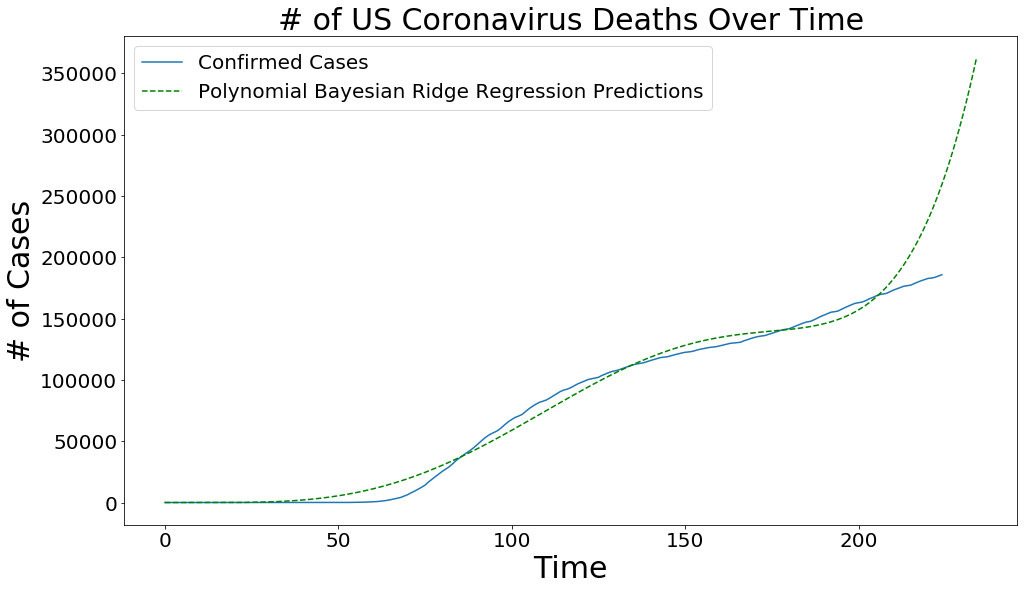

In [81]:
plt.figure(figsize=(16, 9))
plt.plot(death_adjusted_dates, us_deaths)
plt.plot(death_future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of US Coronavirus Deaths Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()